<a href="https://colab.research.google.com/github/yg20029/AI-X_DeepLearning/blob/main/ResNet18_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download

In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision import datasets, transforms, models
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import gc
import torchvision

In [2]:
!pip install kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

100%|██████████| 424M/424M [00:20<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


##Show

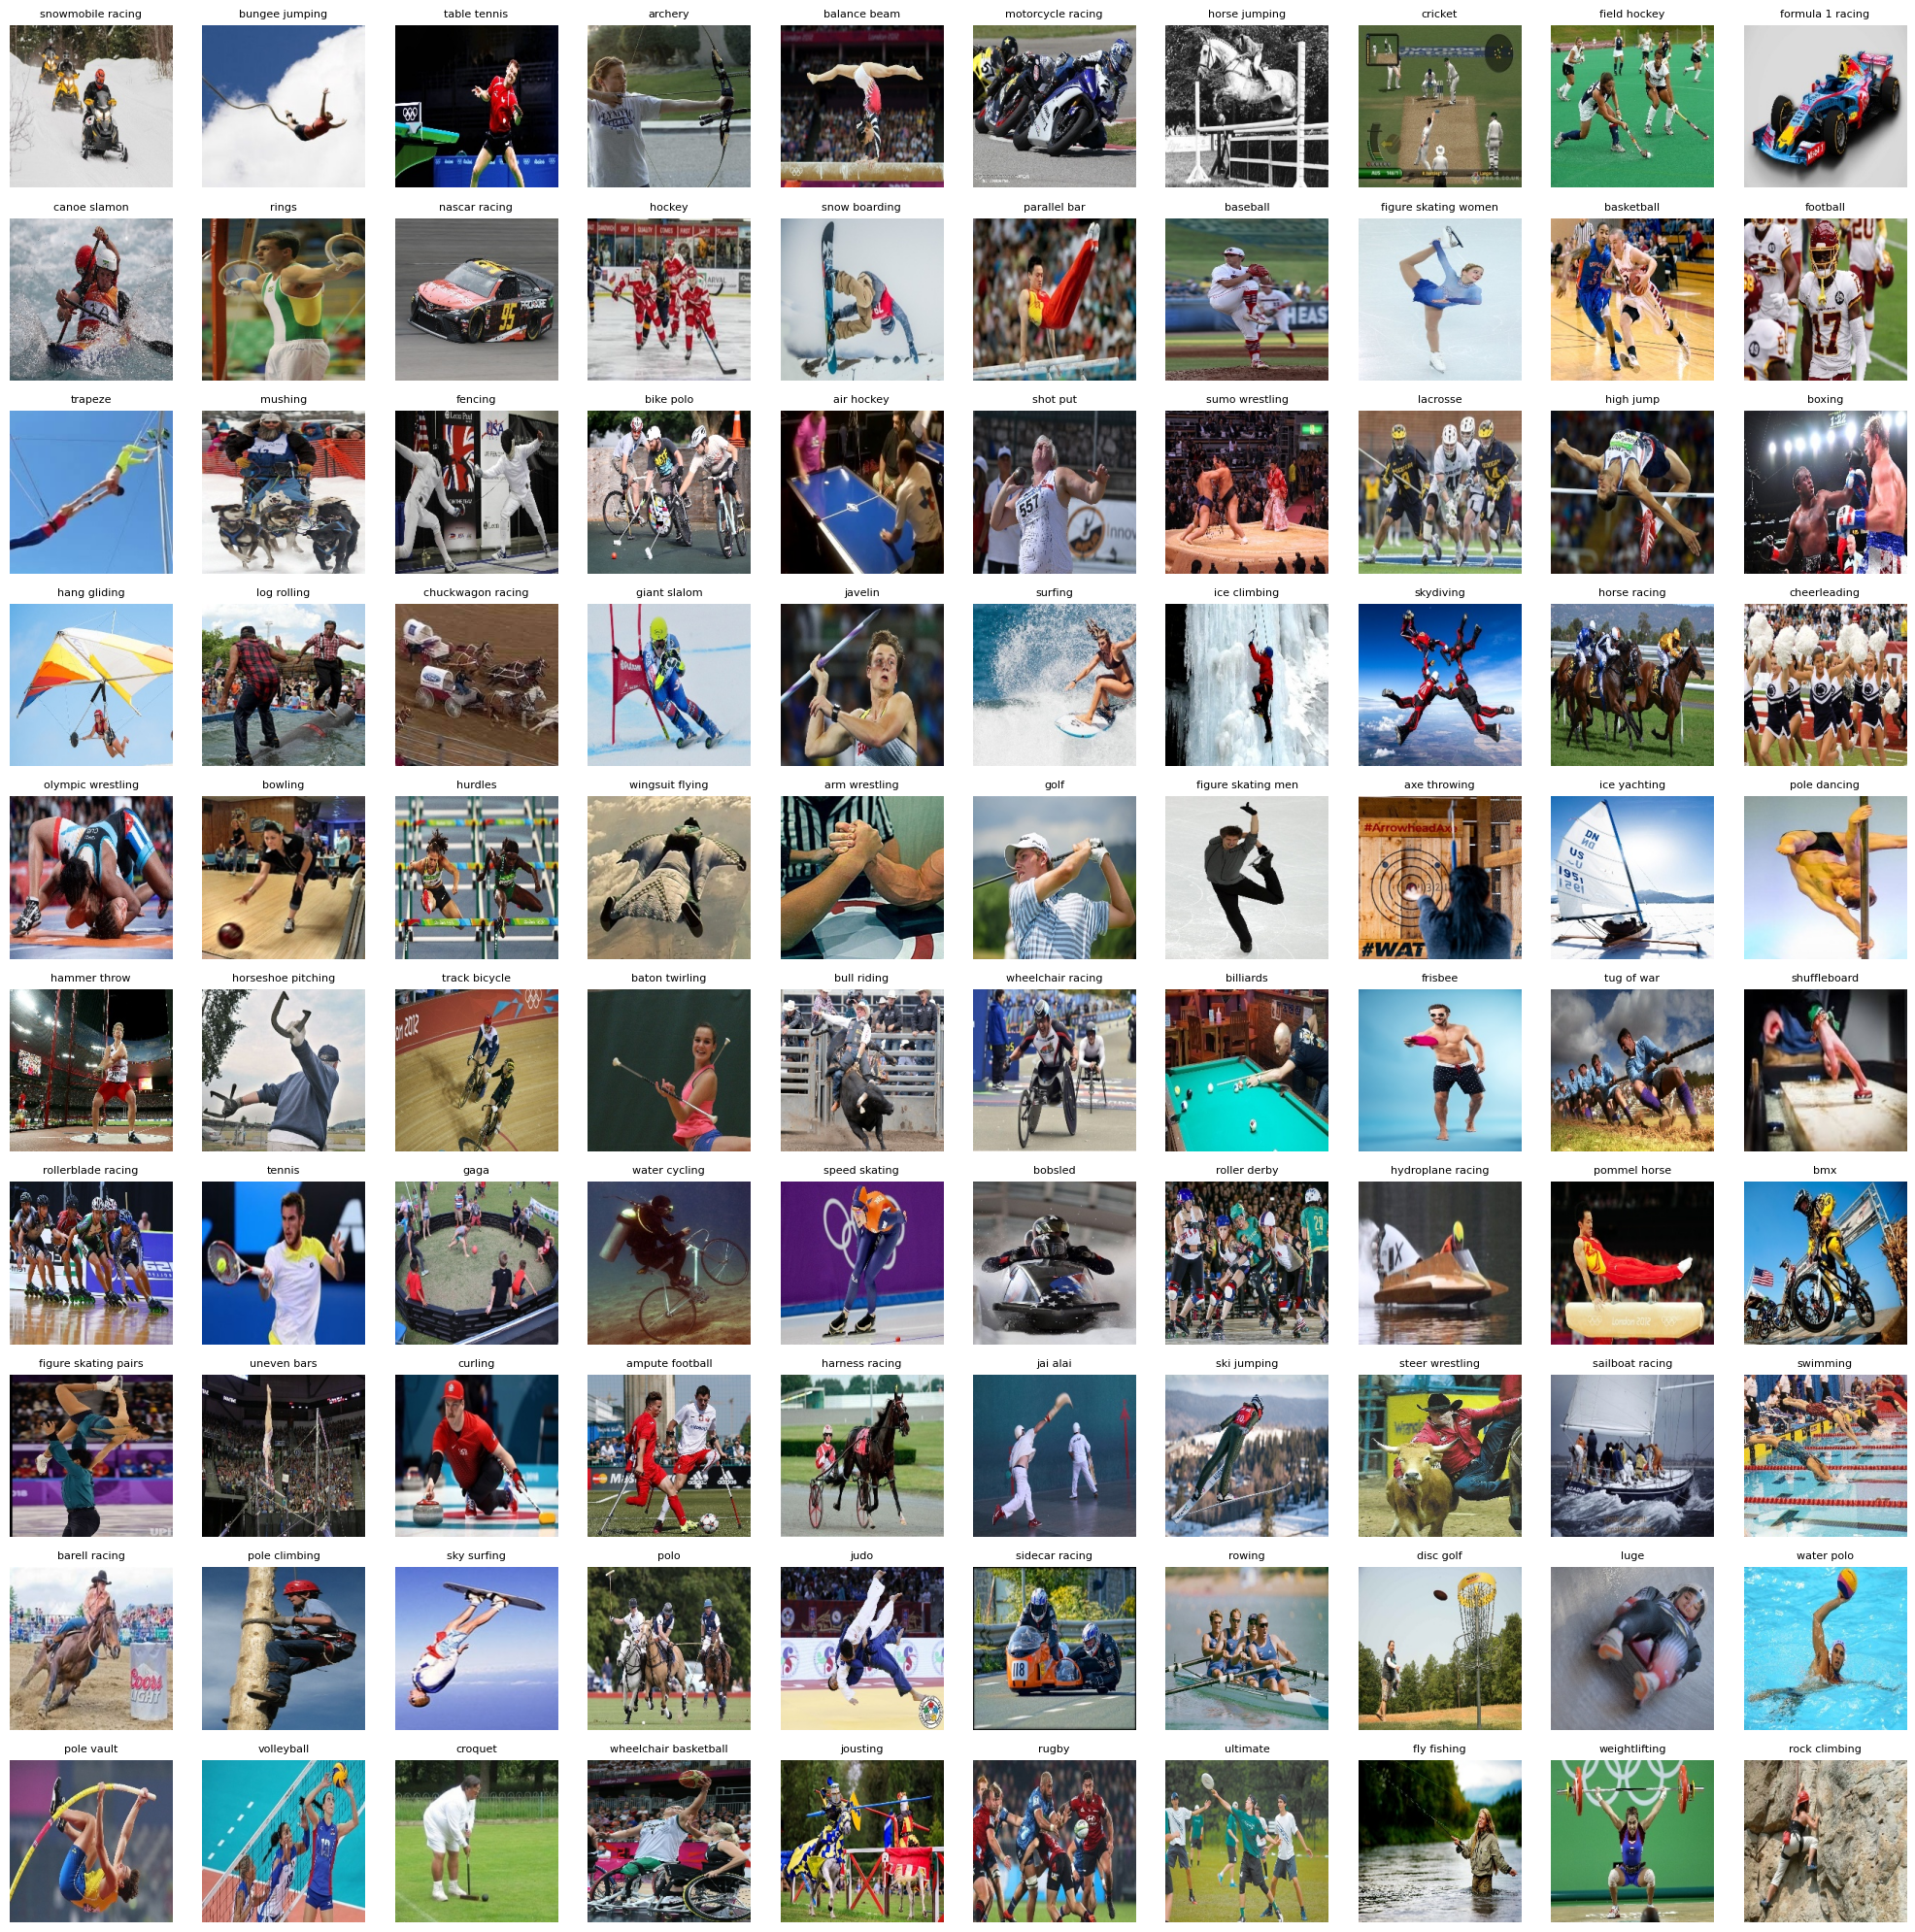

In [ ]:
displayed_labels = {}

# Create a figure for the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Counter for the number of images displayed
image_count = 0

# Iterate through the dataset directory
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):  # Check for image files
            label = os.path.basename(root)  # Assuming label is the folder name
            if label not in displayed_labels:  # Display only one image per label
                image_path = os.path.join(root, file)

                # Open the image
                img = Image.open(image_path)

                # Plot the image in the grid
                axes[image_count].imshow(img)
                axes[image_count].set_title(label, fontsize=8)
                axes[image_count].axis('off')

                # Track displayed labels
                displayed_labels[label] = image_path
                image_count += 1

        # Stop if 100 images have been displayed
        if image_count >= 100:
            break

    # Stop if 100 images have been displayed
    if image_count >= 100:
        break

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

##Code

In [4]:
train_dir = "/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/train"
val_dir = "/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/valid"

In [5]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])

Using device: cuda


###Run

In [6]:
# Check dataset details
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")

# Test loading one batch
print(f"image shape: {train_dataset[0][0].shape}")

Number of classes: 100
Classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'r

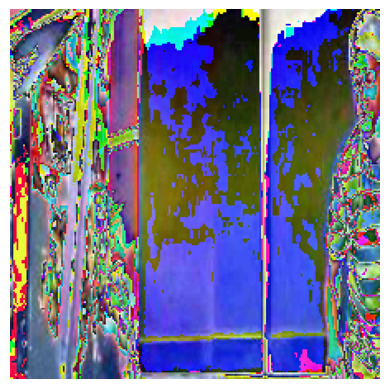

In [7]:
# Assuming `img_tensor` is a tensor you want to visualize
# For example, a tensor with shape [3, H, W]
img_tensor = train_dataset[0][0]

# Convert the tensor to a PIL Image using torchvision.transforms
to_pil = transforms.ToPILImage()
img_pil = to_pil(img_tensor)

# Display the image using matplotlib
plt.imshow(img_pil)
plt.axis('off')  # Turn off axis labels
plt.show()

##wandb

In [8]:
import wandb
import random
from torchvision import models

In [9]:
!pip install wandb

In [10]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
# Define the sweep configuration
sweep_config = {
    'method': 'random',  # Random search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'  # We want to maximize validation accuracy
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'values': [5, 10, 20]
        },
        'weight_decay': {
            'values': [0.001, 0.0001, 0.00001]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="resNet18")

def train_model(config=None):
    # Initialize a new run
    with wandb.init(config=config):
        config = wandb.config

        # Update dataloaders based on batch size
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        # Initialize the model
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, 100)
        model = model.to(device)

        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Define optimizer
        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                del images, labels, outputs
                torch.cuda.empty_cache()

                train_loss += loss.item()


            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    del images, labels, outputs
                    torch.cuda.empty_cache()

            val_accuracy = correct / total
            gc.collect()
            torch.cuda.empty_cache()

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss / len(train_loader),
                'val_loss': val_loss / len(val_loader),
                'val_accuracy': val_accuracy
            })
            print(f"epoch {epoch+1} done.")

        print(f"Run complete. Final validation accuracy: {val_accuracy:.2f}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 5f43zpi0
Sweep URL: https://wandb.ai/apolon0617-hanyang-university/resNet18/sweeps/5f43zpi0


In [12]:
# Run the sweep
wandb.agent(sweep_id, train_model, count = 15)

wandb: Agent Starting Run: olmh8ib1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
wandb: Currently logged in as: apolon0617 (apolon0617-hanyang-university). Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.33


wandb: Agent Starting Run: au9vmpbz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
epoch 11 done.
epoch 12 done.
epoch 13 done.
epoch 14 done.
epoch 15 done.
epoch 16 done.
epoch 17 done.
epoch 18 done.
epoch 19 done.
epoch 20 done.
Run complete. Final validation accuracy: 0.80


wandb: Agent Starting Run: iza4veqt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
epoch 11 done.
epoch 12 done.
epoch 13 done.
epoch 14 done.
epoch 15 done.
epoch 16 done.
epoch 17 done.
epoch 18 done.
epoch 19 done.
epoch 20 done.
Run complete. Final validation accuracy: 0.92


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8t774fwp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
epoch 11 done.
epoch 12 done.
epoch 13 done.
epoch 14 done.
epoch 15 done.
epoch 16 done.
epoch 17 done.
epoch 18 done.
epoch 19 done.
epoch 20 done.
Run complete. Final validation accuracy: 0.74


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 12wxabtx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
epoch 11 done.
epoch 12 done.
epoch 13 done.
epoch 14 done.
epoch 15 done.
epoch 16 done.
epoch 17 done.
epoch 18 done.
epoch 19 done.
epoch 20 done.
Run complete. Final validation accuracy: 0.36


wandb: Agent Starting Run: bpve87ay with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.28


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uqz9u6k0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.73


wandb: Agent Starting Run: nqakzfi1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.82


wandb: Agent Starting Run: gacj74qh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.90


wandb: Agent Starting Run: xuxd05n7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.93


wandb: Agent Starting Run: wjsrh9nb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.87


wandb: Agent Starting Run: y4crj02h with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.91


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqoepwbs with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.85


wandb: Agent Starting Run: lrzjpsly with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
Run complete. Final validation accuracy: 0.93


wandb: Agent Starting Run: ua90a8a4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.53
